linear predictive coding is one of the techniques in speech processing it is a mathematical operation where future values of discrete time are estimated based on the linear function of previous samples in a signals

The LPC model is also a Source filter model wher the source sound goes through filter h(n)and the resulting output is x(n)=h(n)*e(n).
The goal of LPC is to minimize the prediction error it is the source to modelling Vowels




SUMMARY

1.  **Linear Predictive Coding (LPC)**: LPC is a widely used method for 
predicting the future values of a signal based on its past values. It is
used in speech coding, audio compression, and other applications. LPC
models the signal as a linear combination of past values, and the coefficients
of this combination are the prediction coefficients. The prediction error is
then calculated as the difference between the actual signal value and the
predicted value.

In [1]:
#importing libraries 
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import gtts
from gtts import gTTS
import pyaudio


In [2]:
#record the audio
text="HELLO,there how can i help you today"
language='en'
audio='sample_audio.wav'

#convert the text to audio file using librosa
tts=gTTS(text=text,lang=language,slow=False)
tts.save(audio)


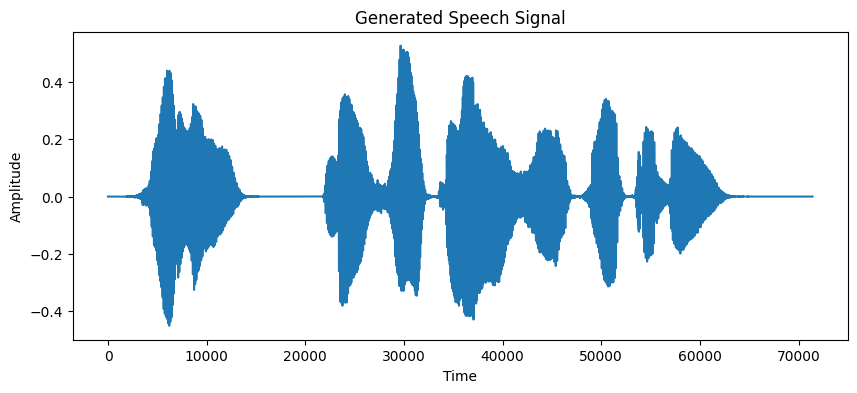

In [3]:
#loading and plotting
signal,sr=librosa.load(audio,sr=None)

# Plot the speech signal
plt.figure(figsize=(10, 4))
plt.plot(signal)
plt.title('Generated Speech Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Levinson durbin algorithm  is a type of algorithm that uses the autocorelation method to estimate the parameters of linear prediction for a particular segment of speech

this algorithm gives a recursive solution  for LP coefficients using to solve the yule walker eqn 
we have r[0],r[1],.....r[p]
the Levinson Durbin algorithm is used to find the LP coefficients a[0],a[1],...a[p]
to minimize the error prediction 


in the below recursion the function of Levinson durbin it solves Yule-Walker equations, which arise from the autocorrelation method used in LPC analysis. The Levinson-Durbin recursion efficiently computes the LPC coefficients from the autocorrelation values. These LPC coefficients describe a predictive model for the signal.




In [4]:
# Step 3: LPC Analysis
def autocorrelation(signal, order):
    """Compute autocorrelation of the input signal for given order."""
    result = np.correlate(signal, signal, mode='full')
    mid = len(result) // 2
    return result[mid:mid + order + 1]

def levinson_durbin(r, order):
    a = np.zeros(order + 1)
    e = np.zeros(order + 1)
    a[0] = 1.0
    e[0] = r[0]  # Initial error

    for k in range(1, order + 1):
        
        alpha = (r[k] - np.dot(a[1:k], r[k-1:0:-1])) / e[k-1]
        
        # Update the LPC coefficients
        a[1:k+1] = a[1:k+1] - alpha * a[k-1::-1]
        a[k] = alpha
        
        # Update prediction error
        e[k] = e[k-1] * (1 - alpha**2)

    return a, e[-1]

def estimate_formants(lpc_coeffs, sample_rate, order):
    roots = np.roots(lpc_coeffs)
    roots = [r for r in roots if np.imag(r) >= 0]
    angles = np.angle(roots)
    formants = sorted(angles * (sample_rate / (2 * np.pi)))
    return formants[:order]


for each recursion in k 
ak= alpha = (r[k] - np.dot(a[1:k], r[k-1:0:-1])) / e[k-1]

where k is the lag  r is auto correlation
a is the coefficients of the AR model
e is the error term



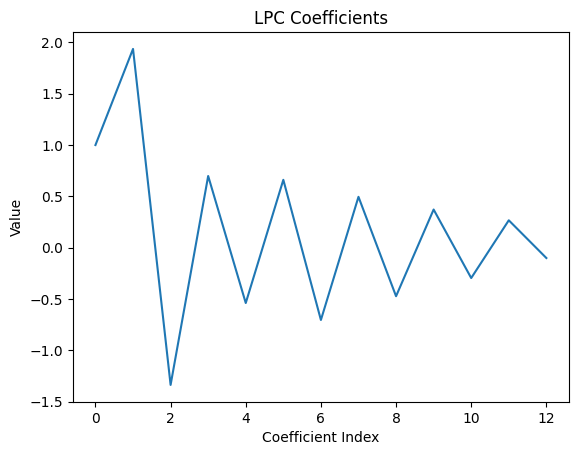

LPC Coefficients: [ 1.          1.93648676 -1.33688925  0.69842158 -0.53894059  0.66118629
 -0.70413094  0.49550818 -0.47266027  0.37184645 -0.2955812   0.26694142
 -0.10054038]
Formants (in Hz): [0.0, 1379.2672964611766, 3536.3499750246406, 5674.378276744817, 7956.500508673869, 9867.62056837482, 12000.0]


In [16]:
lpc_order = 12

# Step 4: Calculate autocorrelation and LPC coefficients
r = autocorrelation(signal, lpc_order)
lpc_coeffs, error = levinson_durbin(r, lpc_order)

# Step 5: Estimate formants from LPC coefficients
formants = estimate_formants(lpc_coeffs, sr, lpc_order)

# Plotting the LPC coefficients
plt.plot(lpc_coeffs)
plt.title("LPC Coefficients")
plt.xlabel("Coefficient Index")
plt.ylabel("Value")
plt.show()

# Output results
print("LPC Coefficients:", lpc_coeffs)
print("Formants (in Hz):", formants)


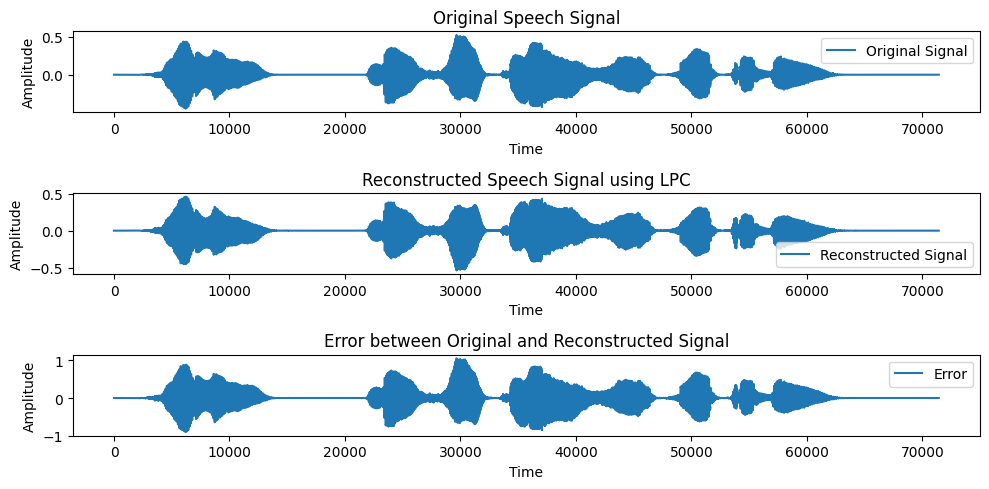

In [17]:
import scipy.signal
#Reconstruct the speech signal from LPC coefficients
# Generate LPC filter
reconstructed_signal = scipy.signal.lfilter([0] + -lpc_coeffs[1:], [1], signal)
error=signal-reconstructed_signal

# Plotting the original and reconstructed signal
plt.figure(figsize=(10,5))
plt.subplot(3, 1, 1)
plt.plot(signal, label="Original Signal")
plt.title("Original Speech Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(reconstructed_signal, label="Reconstructed Signal")
plt.title("Reconstructed Speech Signal using LPC")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(error, label="Error")
plt.title("Error between Original and Reconstructed Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()



plt.tight_layout()
plt.show()

In [18]:
# Output results
print("LPC Coefficients:", lpc_coeffs)
print("Formants (in Hz):", formants)

LPC Coefficients: [ 1.          1.93648676 -1.33688925  0.69842158 -0.53894059  0.66118629
 -0.70413094  0.49550818 -0.47266027  0.37184645 -0.2955812   0.26694142
 -0.10054038]
Formants (in Hz): [0.0, 1379.2672964611766, 3536.3499750246406, 5674.378276744817, 7956.500508673869, 9867.62056837482, 12000.0]


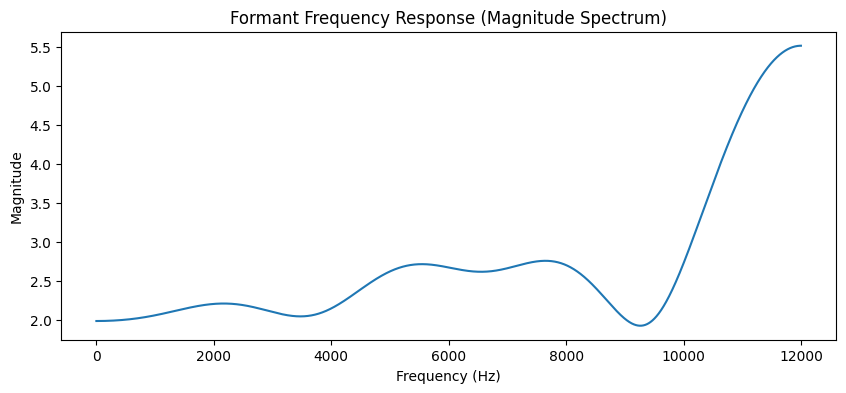

In [8]:
# Step 7: Frequency response plot for formants
w, h = scipy.signal.freqz(lpc_coeffs, worN=8000)
frequencies = (w * sr) / (2 * np.pi)

plt.figure(figsize=(10, 4))
plt.plot(frequencies, np.abs(h))
plt.title('Formant Frequency Response (Magnitude Spectrum)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()


implementation of lpc using librosa library

In [20]:
#implementation of lpc 
order=12
lpc_coefficients=librosa.lpc(signal,order=order)

#display the coefficients
print("lpc_coefficients:")
print(lpc_coefficients)

lpc_coefficients:
[ 1.         -1.9370743   1.3387495  -0.70098615  0.54098934 -0.663654
  0.70695245 -0.4978276   0.4750168  -0.37317497  0.2960297  -0.26734567
  0.10067876]


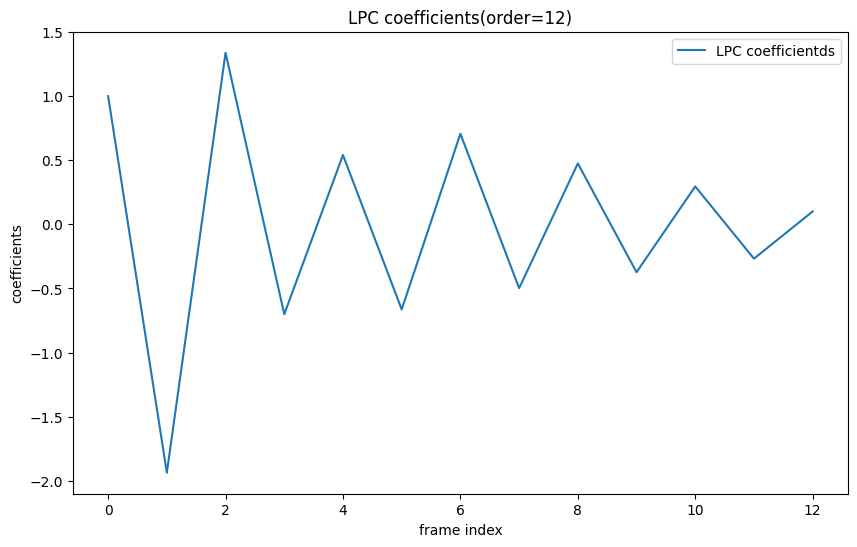

In [21]:
#plot the LPC coefficients
plt.figure(figsize=(10,6))
plt.plot(lpc_coefficients.T,label='LPC coefficientds')
plt.xlabel("frame index")
plt.ylabel("coefficients")
plt.title(f"LPC coefficients(order={order})")
plt.legend()